# Spectral Clustering
---
Spectral clustering for link prediction:
1. Compute eigendecomposition of graph Laplacian
2. Take top K eigenvectors --> node embedding vectors (Z)
3. Edge scores = sigmoid(Z * Z^T)
3. Test scores these scores against actual edge values (ROC AUC, AP)

Scikit-learn documentation: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.spectral_embedding.html

## 1. Read in Graph Data

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import pickle

In [23]:
EGO_USER = 1684 # which ego network to look at

# Load pickled (adj, feat) tuple
network_dir = './fb-processed/{0}-adj-feat.pkl'.format(EGO_USER)
with open(network_dir, 'rb') as f:
    adj, features = pickle.load(f,encoding='latin1')
    
g = nx.Graph(adj) # re-create graph using node indices (0 to num_nodes-1)

<ipython-input-23-90b541d99e81>:6: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  adj, features = pickle.load(f,encoding='latin1')


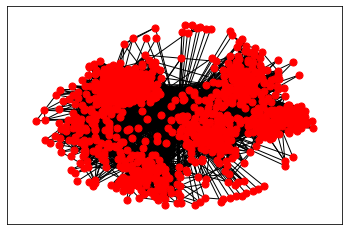

In [18]:
# draw network
nx.draw_networkx(g, with_labels=False, node_size=50, node_color='r')
plt.show()

## 2. Preprocessing/Train-Test Split

In [47]:
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def mask_test_edges(adj, test_frac=.01, prevent_disconnect=True):
    # NOTE: Splits are randomized and results might slightly deviate from reported numbers in the paper.
    # Remove diagonal elements
    #adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    #adj.eliminate_zeros()
    # Check that diag is zero:
    assert np.diag(adj.todense()).sum() == 0
    
    g = nx.from_scipy_sparse_array(adj)
    
    #orig_num_cc = nx.number_connected_components(g)
    adj_triu = sp.triu(adj,k=1) # upper triangular portion of adj matrix
    adj_tuple = sparse_to_tuple(adj_triu) # (coords, values, shape), edges only 1 way
    edges = adj_tuple[0] # all edges, listed only once (not 2 ways)
    # edges_all = sparse_to_tuple(adj)[0] # ALL edges (includes both ways)
    num_test = int(np.floor(edges.shape[0] * test_frac)) # controls how large the test set should be
    # Store edges in list of ordered tuples (node1, node2) where node1 < node2
    edge_tuples = [(min(edge[0], edge[1]), max(edge[0], edge[1])) for edge in edges]
    all_edge_tuples = set(edge_tuples)
    train_edges = set(edge_tuples) # initialize train_edges to have all edges
    test_edges = set()
    
    # Iterate over shuffled edges, add to train/val sets
    np.random.shuffle(edge_tuples)
    for edge in edge_tuples:
        # print edge
        if len(test_edges) == num_test :
            break
        node1 = edge[0]
        node2 = edge[1]  
        # If removing edge would disconnect a connected component, backtrack and move on
        g.remove_edge(node1, node2)
        if prevent_disconnect == True:
            if  nx.is_isolate(g,node1) or nx.is_isolate(g,node2) :
                g.add_edge(node1, node2)
                continue

        # Fill test_edges first
        if len(test_edges) < num_test:
            test_edges.add(edge)
            train_edges.remove(edge)
     # Both edge lists full --> break loop
    if (len(test_edges) < num_test):
        print ("WARNING: not enough removable edges to perform full train-test split!")
        print ("Num. (test, val) edges requested: :",num_test)
        print ("Num. (test, val) edges returned: (", len(test_edges), ")")

    
    test_edges_false = set()
    while len(test_edges_false) < num_test:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge not an actual edge, and not a repeat
        if false_edge in all_edge_tuples:
            continue
        if false_edge in test_edges_false:
            continue

        test_edges_false.add(false_edge)
    # assert: test, val, train positive edges disjoint
    assert test_edges.isdisjoint(train_edges)
    assert test_edges_false.isdisjoint(all_edge_tuples)
    # Re-build adj matrix using remaining graph
    adj_train = g
    
    # Convert edge-lists to numpy arrays
    train_edges = np.array([list(edge_tuple) for edge_tuple in train_edges])
    test_edges = np.array([list(edge_tuple) for edge_tuple in test_edges])
    test_edges_false = np.array([list(edge_tuple) for edge_tuple in test_edges_false])   
    # NOTE: these edge lists only contain single direction of edge!
    
    return adj_train, train_edges,test_edges,test_edges_false


In [24]:

np.random.seed(0) # make sure train-test split is consistent between notebooks
#adj_sparse = nx.to_scipy_sparse_array(g)

# Perform train-test split
g_train, train_edges,test_edges,test_edges_false = mask_test_edges(adj, test_frac=.3)

adj_train = nx.to_scipy_sparse_array(g_train) # new graph object with only non-hidden edges
# from gae.preprocessing import mask_test_edges
# np.random.seed(0) # make sure train-test split is consistent between notebooks
# adj_sparse = nx.to_scipy_sparse_matrix(g)

# # Perform train-test split
# adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
#     test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.3, val_frac=.1)
# g_train = nx.from_scipy_sparse_matrix(adj_train) # new graph object with only non-hidden edges

end split test


In [25]:
# Inspect train/test split
print ("Total nodes:", adj_train.shape[0])
print ("Total edges:", int(adj_train.nnz/2)) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print ("Training edges (positive):", len(train_edges))
#print( "Training edges (negative):", len(train_edges_false))
#print ("Validation edges (positive):", len(val_edges))
#print ("Validation edges (negative):", len(val_edges_false))
print ("Test edges (positive):", len(test_edges))
print ("Test edges (negative):", len(test_edges_false))

Total nodes: 793
Total edges: 10372
Training edges (positive): 10372
Test edges (positive): 4444
Test edges (negative): 4444


In [9]:
def get_roc_score(edges_pos, edges_neg, embeddings):
    score_matrix = np.dot(embeddings, embeddings.T)
    
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    # Store positive edge predictions, actual values
    preds_pos = []
    pos = []
    for edge in edges_pos:
        preds_pos.append(sigmoid(score_matrix[edge[0], edge[1]])) # predicted score
        pos.append(adj_train[edge[0], edge[1]]) # actual value (1 for positive)
        
    # Store negative edge predictions, actual values
    preds_neg = []
    neg = []
    for edge in edges_neg:
        preds_neg.append(sigmoid(score_matrix[edge[0], edge[1]])) # predicted score
        neg.append(adj_train[edge[0], edge[1]]) # actual value (0 for negative)
        
    # Calculate scores
    preds_all = np.hstack([preds_pos, preds_neg])
    labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    return roc_score, ap_score

## 3. Spectral Clustering

In [12]:
adj_train

<348x348 sparse array of type '<class 'numpy.int64'>'
	with 4014 stored elements in Compressed Sparse Row format>

In [28]:
from sklearn.manifold import spectral_embedding
adj =nx.adjacency_matrix(g_train)
# Get spectral embeddings (16-dim)
emb = spectral_embedding(adj, n_components=32, random_state=0)

<ipython-input-28-359e4e6f6a9f>:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj =nx.adjacency_matrix(g_train)
/Users/mac/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [29]:
# Calculate ROC AUC and Average Precision
sc_roc, sc_ap = get_roc_score(test_edges, test_edges_false, emb)

print ('Spectral Clustering Test ROC score: ', str(sc_roc))
print ('Spectral Clustering Test AP score: ', str(sc_ap))

Spectral Clustering Test ROC score:  0.8649441930016584
Spectral Clustering Test AP score:  0.8395840604400371


# testing componentes

100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


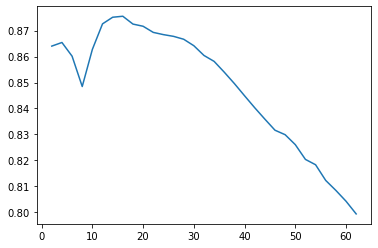

In [50]:
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
EGO_USER = 1684 # which ego network to look at
# Load pickled (adj, feat) tuple
network_dir = './fb-processed/{0}-adj-feat.pkl'.format(EGO_USER)
with open(network_dir, 'rb') as f:
    adj, features = pickle.load(f,encoding='latin1')
    
g = nx.Graph(adj) # re-create graph using node indices (0 to num_nodes-1)

components = range(2,64,2)
Roc = []
ap = []
for com in (components):
    tem=[]
    for i in tqdm(range(50)):
        g_train, train_edges,test_edges,test_edges_false = mask_test_edges(adj, test_frac=.3)
        adj_train = nx.to_scipy_sparse_array(g_train) 
        adj_trainf =nx.adjacency_matrix(g_train)
        emb = spectral_embedding(adj_trainf, n_components=com)
        sc_roc, sc_ap = get_roc_score(test_edges, test_edges_false, emb)
       
        tem.append(sc_roc)
    m=np.array(tem).mean()
    
    Roc.append(m)
  


plt.plot(components,Roc)

In [57]:
import warnings
warnings.filterwarnings("ignore")
EGO_USERs =[0,107,348,414,686,698,1684,1912,3437,3980]
Roc = []
ap = []

for EGO_USER in EGO_USERs:
    
    # Load pickled (adj, feat) tuple
    network_dir = './fb-processed/{0}-adj-feat.pkl'.format(EGO_USER)
    with open(network_dir, 'rb') as f:
        adj, features = pickle.load(f,encoding='latin1')
        
    g = nx.Graph(adj) # re-create graph using node indices (0 to num_nodes-1)

    tmp_roc=[]
    tmp_ap=[]
   
    for i in tqdm(range(50)):
            g_train, train_edges,test_edges,test_edges_false = mask_test_edges(adj, test_frac=.3)
            adj_train = nx.to_scipy_sparse_array(g_train) 
            adj_trainf =nx.adjacency_matrix(g_train)
            emb = spectral_embedding(adj_trainf, n_components=16)
            sc_roc, sc_ap = get_roc_score(test_edges, test_edges_false, emb)
        
            tmp_roc.append(sc_roc)
            tmp_ap.append(sc_ap)
    a=np.array(tmp_roc).mean()
    Roc.append(a)
    m=np.array(tmp_ap).mean()
    ap.append(m)
    print(f'ego: {EGO_USER} Roc= {a} and AP={m}')
    




100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


ego: 0 Roc= 0.8304926539645281 and AP=0.7930145295210852


  0%|          | 0/50 [00:00<?, ?it/s]

ego: 107 Roc= 0.890923975353845 and AP=0.8369242978570216


  2%|▏         | 1/50 [00:00<00:06,  7.74it/s]

ego: 348 Roc= 0.788323264723379 and AP=0.7371980951752636


  0%|          | 0/50 [00:00<?, ?it/s]

ego: 414 Roc= 0.6924935638341044 and AP=0.6656701191125891


  8%|▊         | 4/50 [00:00<00:01, 32.51it/s]

ego: 686 Roc= 0.7178347576443223 and AP=0.6699702326472387


100%|██████████| 50/50 [00:01<00:00, 35.88it/s]


ego: 698 Roc= 0.4633910000000001 and AP=0.555862326763796


100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


ego: 1684 Roc= 0.8736728740943401 and AP=0.819072165821551


  0%|          | 0/50 [00:00<?, ?it/s]

ego: 1912 Roc= 0.8901230995582852 and AP=0.8125632375692123


  6%|▌         | 3/50 [00:00<00:01, 25.01it/s]

ego: 3437 Roc= 0.9114184286898839 and AP=0.8967833190425112


100%|██████████| 50/50 [00:01<00:00, 44.98it/s]

ego: 3980 Roc= 0.5128540714861596 and AP=0.5441771838723612


In [56]:
a.argmax()

7

In [43]:
l=[1,3,5]
np.array(l).mean()
l.append(3)

In [58]:
Roc

[0.8304926539645281,
 0.890923975353845,
 0.788323264723379,
 0.6924935638341044,
 0.7178347576443223,
 0.4633910000000001,
 0.8736728740943401,
 0.8901230995582852,
 0.9114184286898839,
 0.5128540714861596]

In [59]:
dic={

    'roc':Roc,
    'ap':ap,

}
results =pd.DataFrame(dic,index=EGO_USERs)
results

,roc,ap
0,0.830493,0.793015
107,0.890924,0.836924
348,0.788323,0.737198
414,0.692494,0.665670
686,0.717835,0.669970
698,0.463391,0.555862
1684,0.873673,0.819072
1912,0.890123,0.812563
3437,0.911418,0.896783
3980,0.512854,0.544177
